# Goals:
- Accuracy using complete dataset to predict from GLM + RF in HOTS
- Accuracy using only cast measurements to predict from GLM + RF in HOTS
- Save RF and GLM models for both cases, document variable names

In [2]:
library(tidyverse)
library(flextable)
library(randomForest)
library(ggdark)


### Read in the raw data

In [4]:
complete.hots <- read.csv("..\\data\\parsed\\ideal-variables-2022.csv")
complete.hots <- complete.hots %>% select(-X, -crn, -stn, -cast)
nrow(complete.hots)

[1] 2050

### Center and Scale Data

In [5]:
scaled.hots <- as.data.frame(scale(complete.hots, center = TRUE))
head(scaled.hots)

,press,theta,sigma,temp,csal,coxy,dic,ph,alk,phos,nit,sil,doc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.58625422,1.1900681,-1.1637046,1.1930152,1.1757594,0.9376275,-1.2159665,1.2506828,-0.3260924,-1.1047632,-1.0877768,-0.8562089,0.9928075
2,-0.25479628,-0.6569428,0.5606737,-0.6643846,-1.4488242,-0.6427110,0.4375217,-0.8328306,-0.8323321,0.7041805,0.6797273,0.0343405,-0.6370566
3,-0.02597422,-0.9237807,0.8903636,-0.9315410,-0.7775051,-1.7708889,1.2058790,-1.3968161,0.2775010,1.3537557,1.2961233,0.8683776,-0.7198149
4,-0.69089438,1.3126414,-1.4960586,1.3134947,0.5478627,0.8738803,-1.3665976,1.2973822,-0.4623877,-1.0800958,-1.0900941,-0.8513100,1.5752783
5,-0.67486013,1.2754628,-1.3988168,1.2765096,0.7180979,0.8872227,-1.3140840,1.2506828,-0.3650339,-1.0800958,-1.0900941,-0.8562089,1.7144387
6,-0.65723916,1.2119106,-1.2509558,1.2129996,0.9268211,0.9035301,-1.2422233,1.2434983,-0.4234462,-1.0883183,-1.0895148,-0.8565588,1.1836259


### Quick Function to generate test/train splits

In [6]:
train.test.split <- function(n, test.p){
    test.num = floor(n*test.p)
    test.indices = sample(1:n, test.num, replace = FALSE)
    train.indices = 1:n
    train.indice = train.indices[!train.indices %in% test.indices]
    
    return(list(test.indices = test.indices, train.indices= train.indices))
}

In [7]:
splits <- train.test.split(nrow(scaled.hots),0.5)
#splits$test.indices

### Let's start modeling.
### First we'll try to predict an interesting variable (pH) with all the other rows

In [8]:
ph.complete.glm <- glm(ph ~ . , data = scaled.hots[splits$train.indices,])

In [9]:
summary(ph.complete.glm)


Call:
glm(formula = ph ~ ., data = scaled.hots[splits$train.indices, 
    ])

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.224166  -0.018198   0.000656   0.019091   0.187931  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.380e-15  7.209e-04   0.000 1.000000    
press       -2.197e-01  3.332e-02  -6.594 5.42e-11 ***
theta       -1.555e+01  2.382e+00  -6.528 8.42e-11 ***
sigma       -1.932e-01  5.435e-02  -3.556 0.000386 ***
temp         1.517e+01  2.332e+00   6.507 9.61e-11 ***
csal         9.812e-02  1.370e-02   7.163 1.10e-12 ***
coxy         1.356e-01  9.351e-03  14.497  < 2e-16 ***
dic         -7.005e-01  1.666e-02 -42.056  < 2e-16 ***
alk          9.772e-02  9.282e-03  10.528  < 2e-16 ***
phos        -1.120e-01  2.973e-02  -3.768 0.000170 ***
nit         -3.448e-01  3.704e-02  -9.310  < 2e-16 ***
sil          3.005e-01  1.609e-02  18.680  < 2e-16 ***
doc          3.440e-03  2.307e-03   1.491 0.136208    
---

## A GLM fit does pretty well, apparently theres some significant correlations all over the data

In [10]:
#plot(ph.complete.glm)

In [11]:
predicted.ph <- predict(ph.complete.glm, newdata = scaled.hots[splits$test.indices,])

In [12]:
prediction.dat <- scaled.hots[splits$test.indices,]
prediction.dat$preds <- predicted.ph

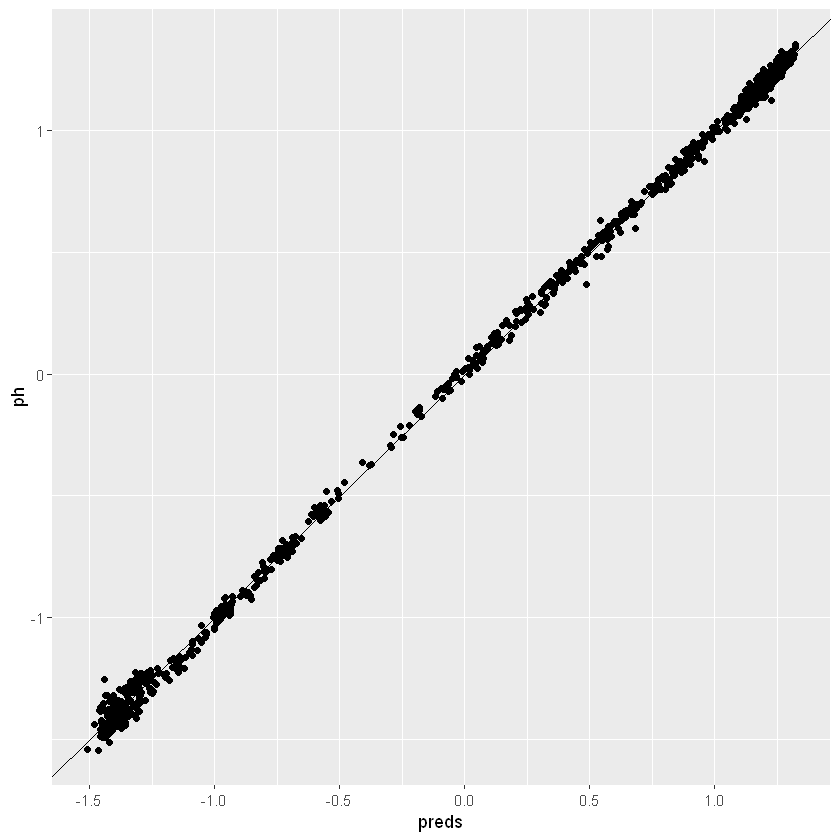

In [13]:
ggplot(prediction.dat) + 
    geom_point(aes(x = preds, y = ph)) +
    geom_abline(slope = 1)

In [14]:
CV <- mean(sqrt((prediction.dat$ph - prediction.dat$preds)^2))

In [15]:
CV#*sqrt(var(complete.hots$sil))

[1] 0.02413114

# Those seem like solid predictions... Let's see what we can do with less data

In [16]:
ph.minimal.glm <- glm(ph ~ temp + csal + press + coxy , data = scaled.hots[splits$train.indices,])

In [17]:
summary(ph.minimal.glm)


Call:
glm(formula = ph ~ temp + csal + press + coxy, data = scaled.hots[splits$train.indices, 
    ])

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.279280  -0.056786   0.007566   0.055890   0.297936  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.763e-15  1.695e-03   0.000    1.000    
temp         4.633e-01  7.480e-03  61.934   <2e-16 ***
csal         1.091e-01  3.730e-03  29.241   <2e-16 ***
press        1.077e-02  4.231e-03   2.545    0.011 *  
coxy         5.136e-01  3.642e-03 141.031   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 0.005887812)

    Null deviance: 2049.000  on 2049  degrees of freedom
Residual deviance:   12.041  on 2045  degrees of freedom
AIC: -4701.8

Number of Fisher Scoring iterations: 2


In [18]:
#plot(sil.minimal.glm)

[1] 0.0621706

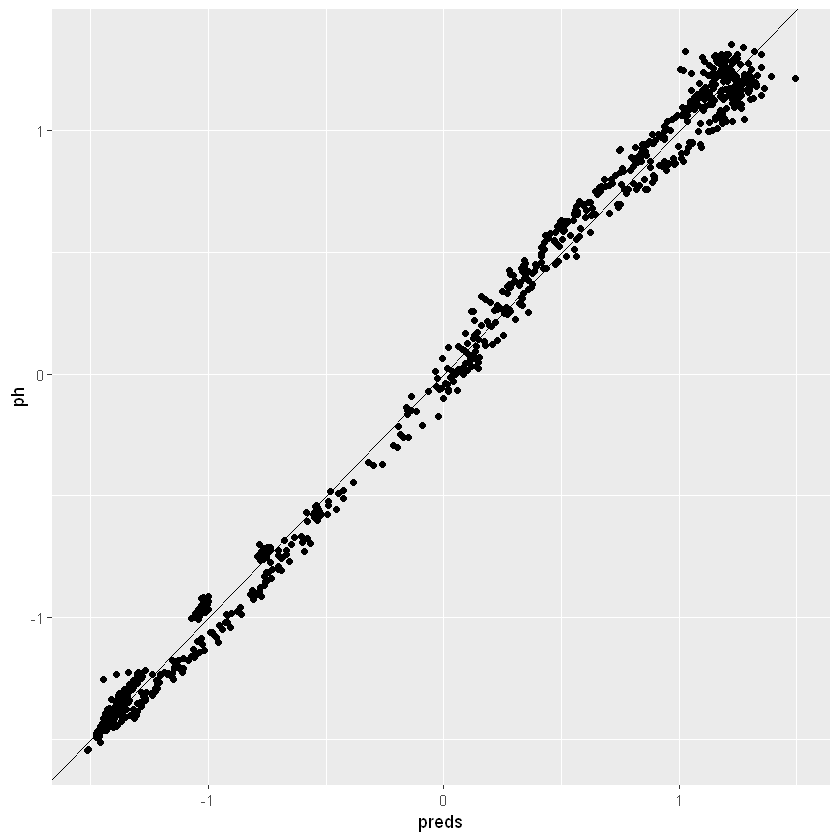

In [19]:
minimal.predicted.ph <- predict(ph.minimal.glm, newdata = scaled.hots[splits$test.indices,])
minimal.prediction.dat <- scaled.hots[splits$test.indices,]
minimal.prediction.dat$preds <- minimal.predicted.ph

ggplot(minimal.prediction.dat) + geom_point(aes(x = preds, y = ph)) + geom_abline(slope = 1)

CV <- mean(sqrt((minimal.prediction.dat$ph - minimal.prediction.dat$preds)^2))
CV

# Not as good, but there's something there. Maybe we need more flexibility to pick up some non-linearities, lets try a random forest

## As a comparison we'll use the entire dataset again

### Use pH first

[1] 0.006655556

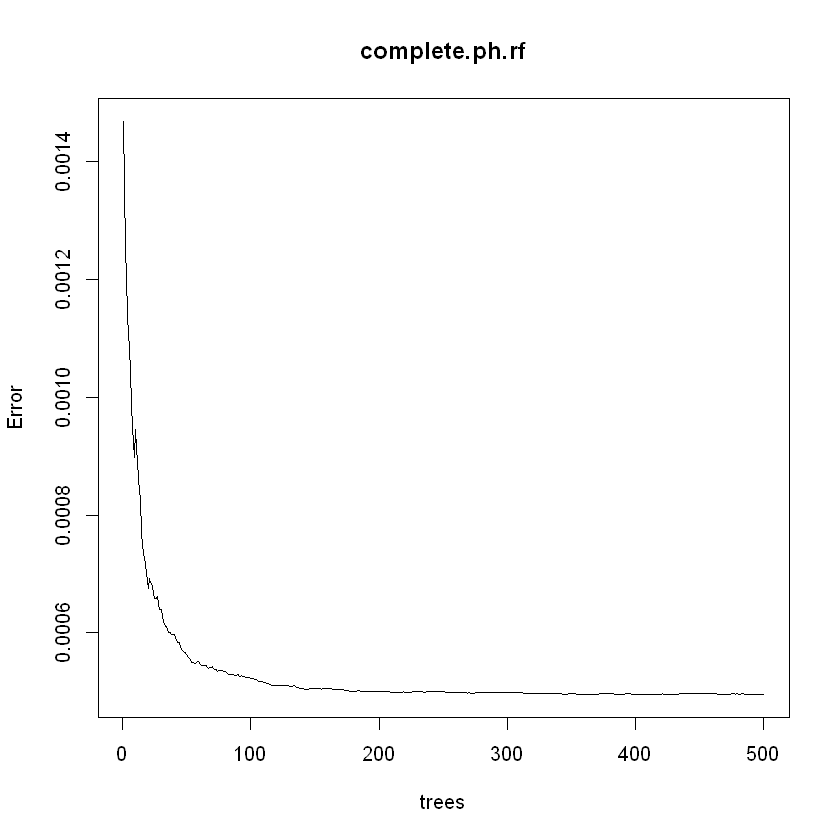

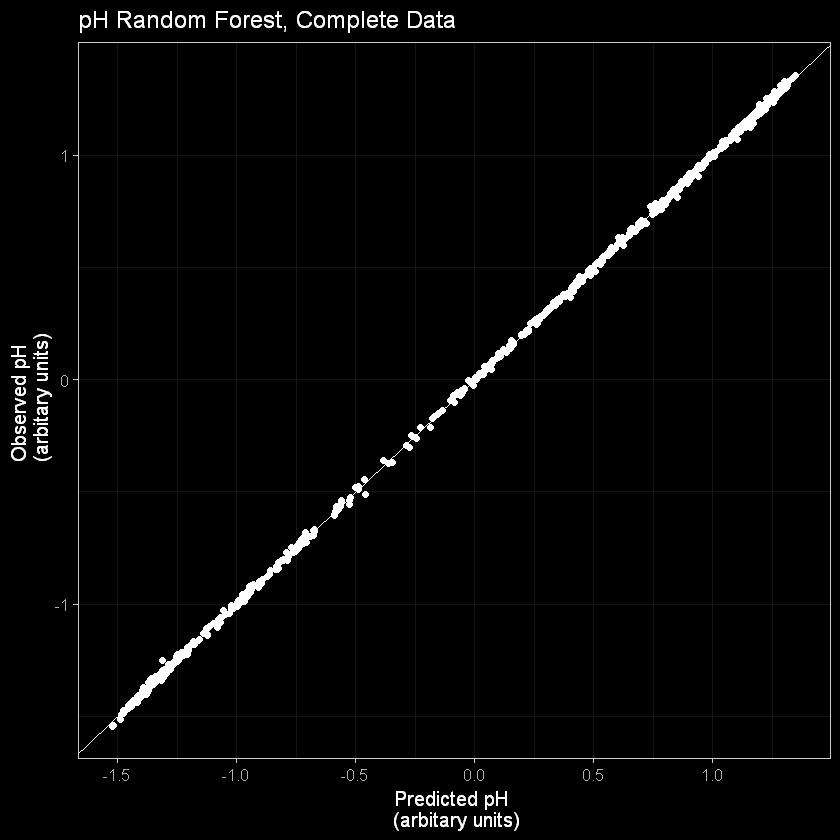

In [21]:
complete.ph.rf <- randomForest(ph ~ . , data = scaled.hots[splits$train.indices,])
plot(complete.ph.rf)
complete.predicted.ph <- predict(complete.ph.rf, newdata = scaled.hots[splits$test.indices,])
complete.rf.prediction.dat <- scaled.hots[splits$test.indices,]
complete.rf.prediction.dat$preds <- complete.predicted.ph
CV <- mean(sqrt((complete.rf.prediction.dat$ph - complete.rf.prediction.dat$preds)^2))
CV

p <- ggplot(complete.rf.prediction.dat) + 
        geom_point(aes(x = preds, y = ph)) + 
        geom_abline() + 
        labs(x = "Predicted pH \n (arbitary units)",
             y = "Observed pH \n (arbitary units)",
             title = "pH Random Forest, Complete Data") + 
        dark_theme_bw(base_size =12) 
p
#ggsave("pH_accuracy_RF_complete_data.svg", p, width = 89, height = 89, units = "mm")

[1] 0.006538483

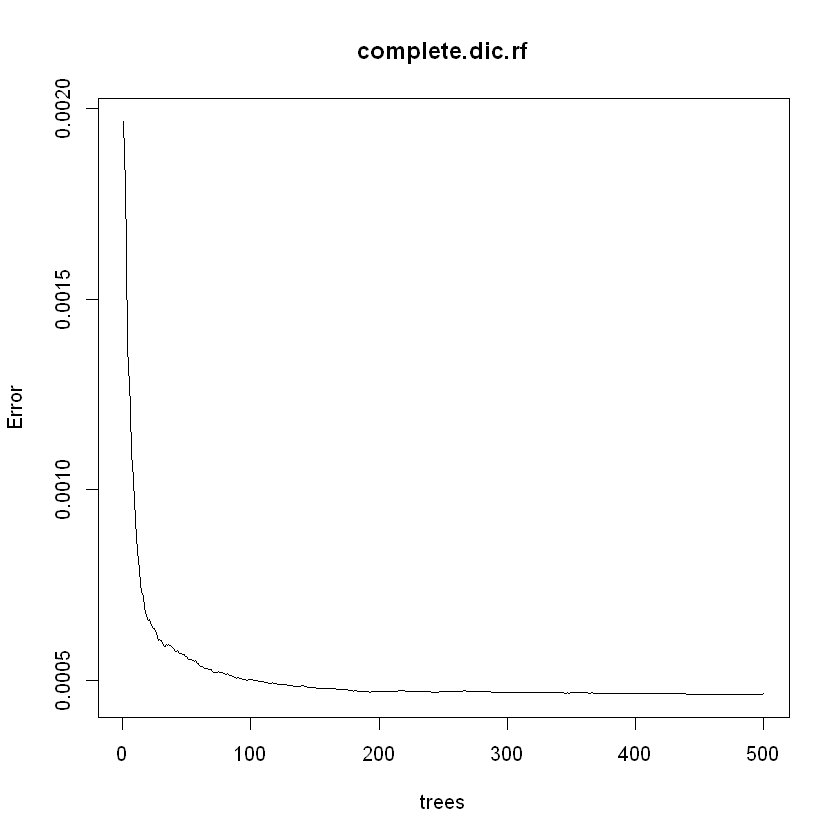

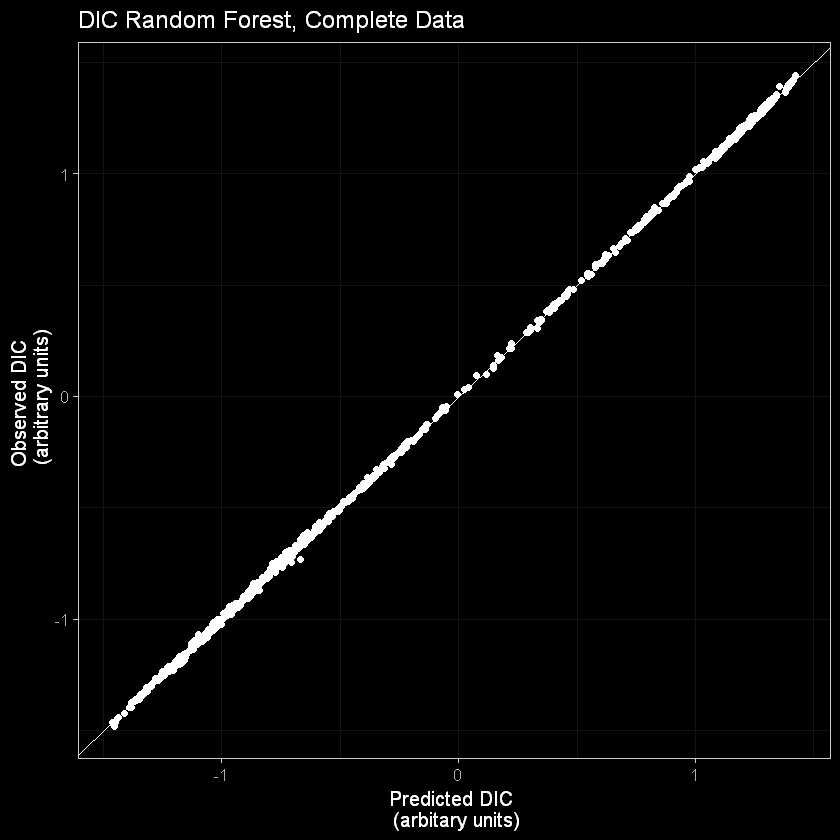

In [22]:
complete.dic.rf <- randomForest(dic ~ . , data = scaled.hots[splits$train.indices,])
plot(complete.dic.rf)
complete.predicted.dic <- predict(complete.dic.rf, newdata = scaled.hots[splits$test.indices,])
complete.rf.prediction.dat <- scaled.hots[splits$test.indices,]
complete.rf.prediction.dat$preds <- complete.predicted.dic
CV <- mean(sqrt((complete.rf.prediction.dat$dic - complete.rf.prediction.dat$preds)^2))
CV

p <- ggplot(complete.rf.prediction.dat) + 
        geom_point(aes(x = preds, y = dic)) + 
        geom_abline() + 
        labs(x = "Predicted DIC \n (arbitary units)",
             y = "Observed DIC \n (arbitrary units)",
             title = "DIC Random Forest, Complete Data") + 
        dark_theme_bw(base_size =12) 
p
# ggsave("dic_accuracy_RF_complete_data.svg", p, width = 89, height = 89, units = "mm")

# Seems consistent with the glm model we had. Let's reduce the input varaibles and see how we do 

[1] 0.9998277

[1] 0.013289

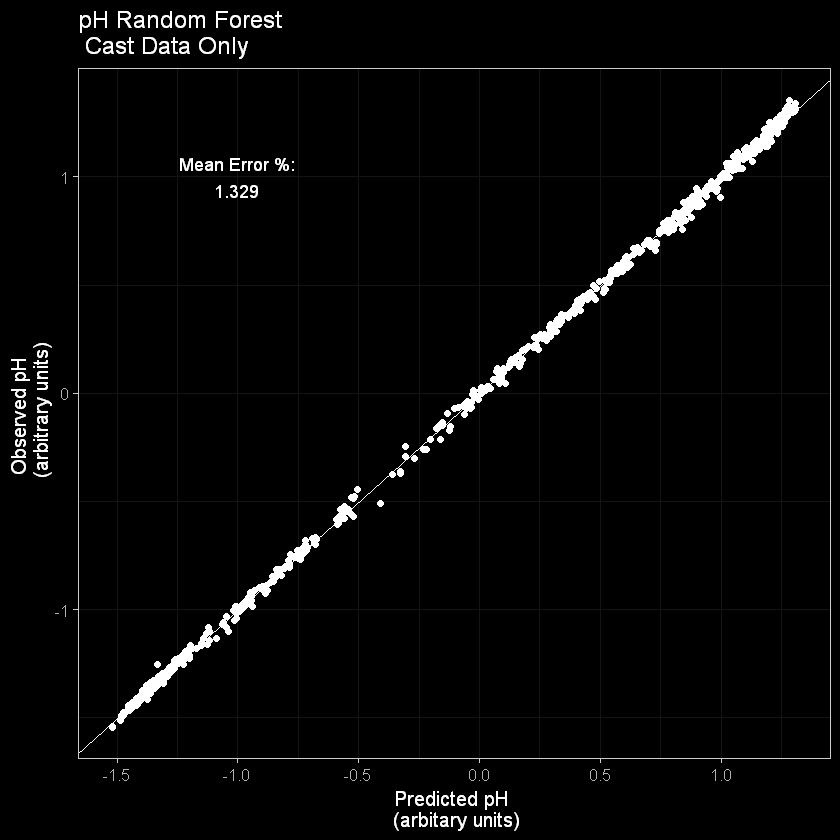

In [24]:
minimal.ph.rf <- randomForest(ph ~ temp + csal + press + coxy  , data = scaled.hots[splits$train.indices,])

minimal.predicted.ph.rf <- predict(minimal.ph.rf, newdata = scaled.hots[splits$test.indices,])
minimal.rf.prediction.dat <- scaled.hots[splits$test.indices,]
minimal.rf.prediction.dat$preds <- minimal.predicted.ph.rf

cor(minimal.rf.prediction.dat$preds, minimal.rf.prediction.dat$ph)
CV <- mean(sqrt((minimal.rf.prediction.dat$ph - minimal.rf.prediction.dat$preds)^2))
CV

p <- ggplot(minimal.rf.prediction.dat) + 
        geom_point(aes(x = preds, y = ph)) + 
        geom_abline(slope = 1) +
        labs(x = "Predicted pH \n (arbitary units)",
             y = "Observed pH \n (arbitrary units)",
             title = "pH Random Forest \n Cast Data Only") + 
        dark_theme_bw(base_size = 12) +
        annotate("text", x = -1, y = 1, 
                 label = paste0("Mean Error %:\n",round(CV*100, digits=3) ))
p
# ggsave("pH_accuracy_RF_cast_data.svg", p, width = 89, height = 89, units = "mm")

[1] 0.9997574

[1] 0.0150916

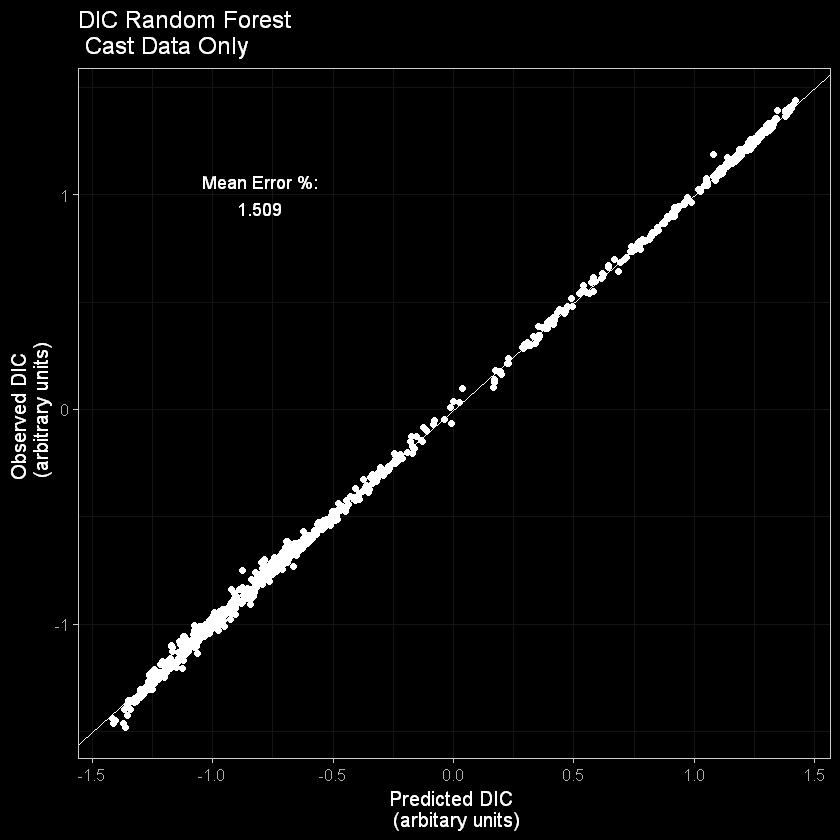

In [25]:
minimal.dic.rf <- randomForest(dic ~ temp + csal + press + coxy  , data = scaled.hots[splits$train.indices,])
minimal.predicted.dic.rf <- predict(minimal.dic.rf, newdata = scaled.hots[splits$test.indices,])
minimal.rf.prediction.dat <- scaled.hots[splits$test.indices,]
minimal.rf.prediction.dat$preds <- minimal.predicted.dic.rf

cor(minimal.rf.prediction.dat$preds, minimal.rf.prediction.dat$dic)
CV <- mean(sqrt((minimal.rf.prediction.dat$dic - minimal.rf.prediction.dat$preds)^2))
CV

p <- ggplot(minimal.rf.prediction.dat) + 
        geom_point(aes(x = preds, y = dic)) + 
        geom_abline(slope = 1) +
        labs(x = "Predicted DIC \n (arbitary units)",
             y = "Observed DIC \n (arbitrary units)",
             title = "DIC Random Forest \n Cast Data Only") + 
        dark_theme_bw(base_size = 12) +
        annotate("text", x = -0.8, y = 1, 
                 label = paste0("Mean Error %:\n",round(CV*100, digits=3) )) 
p
# ggsave("DIC_accuracy_RF_cast_data.svg", p, width = 89, height = 89, units = "mm")

## Much better than the glm, a couple outliers, but this looks pretty great. Let's see how this does with other variables

In [26]:
all.vars <- names(scaled.hots)
all.vars

[1] "press" "theta" "sigma" "temp"  "csal"  "coxy"  "dic"   "ph"    "alk"  
[10] "phos"  "nit"   "sil"   "doc"

In [27]:
predictor.vars <- c("temp", "press", "csal", "coxy")
measurable.vars <- all.vars[!all.vars %in% predictor.vars]
measurable.vars

measurable.vars

[1] "theta" "sigma" "dic"   "ph"    "alk"   "phos"  "nit"   "sil"   "doc"

[1] "theta" "sigma" "dic"   "ph"    "alk"   "phos"  "nit"   "sil"   "doc"

In [28]:
splits <- train.test.split(nrow(scaled.hots), 0.5)
get.cv.cor.rf <- function(scaled.hots, splits, measurable.vars, predictor.vars){
    
    results = data.frame(correlation = c(), cv = c(), variable = c() )
    for (var in measurable.vars){
        print(var)
        flush.console()
        predictors = paste(predictor.vars, collapse = " + ")
        form <- formula(paste0(var, " ~ ",  predictors))
        model_save_name = paste0("models/RF_",var, "_cast_vars.RData")
        model <- randomForest(form, data =scaled.hots[splits$train.indices,])
        save(model, file=model_save_name)
        predictions <- predict(model, newdata = scaled.hots[splits$test.indices,])
        pred.dat <- scaled.hots[splits$test.indices,]
        pred.dat$preds <- predictions
        
        cor.value <- round(cor(pred.dat$preds, pred.dat[,var]), digits = 3)
        
        CV <- sum(sqrt( (pred.dat$preds - pred.dat[var])^2))/length(pred.dat$preds)
        
        this.dat <- data.frame(correlation= cor.value, cv= CV, variable = var)
        results <- rbind(results, this.dat)
                        
    }
    
    return(results)
}

get.cv.cor.glm <- function(scaled.hots, splits, measurable.vars, predictor.vars){
    
    results = data.frame(correlation = c(), cv = c(), variable = c() )
    for (var in measurable.vars){
        print(var)
        flush.console()
        predictors = paste(predictor.vars, collapse = " + ")
        form <- formula(paste0(var, " ~ ",  predictors))
        model_save_name = paste0("models/GLM_",var, "_cast_vars.RData")
        model <- glm(form, data =scaled.hots[splits$train.indices,])
        save(model,file=model_save_name)
        predictions <- predict(model, newdata = scaled.hots[splits$test.indices,])
        pred.dat <- scaled.hots[splits$test.indices,]
        pred.dat$preds <- predictions
        
        cor.value <- round(cor(pred.dat$preds, pred.dat[,var]), digits = 3)
        
        CV <- sum(sqrt( (pred.dat$preds - pred.dat[var])^2))/length(pred.dat$preds)
        
        this.dat <- data.frame(correlation= cor.value, cv= CV, variable = var)
        results <- rbind(results, this.dat)
                        
    }
    
    return(results)
}

In [29]:
cv.corrs.rf <- get.cv.cor.rf(scaled.hots, splits, measurable.vars, predictor.vars)
cv.corrs.glm <- get.cv.cor.glm(scaled.hots, splits, measurable.vars, predictor.vars)

[1] "theta"
[1] "sigma"
[1] "dic"
[1] "ph"
[1] "alk"
[1] "phos"
[1] "nit"
[1] "sil"
[1] "doc"
[1] "theta"
[1] "sigma"
[1] "dic"
[1] "ph"
[1] "alk"
[1] "phos"
[1] "nit"
[1] "sil"
[1] "doc"


In [30]:
cv.corrs.rf$cv <- round(cv.corrs.rf$cv*100.0, digits = 3)
cv.corrs.glm$cv <- round(cv.corrs.glm$cv*100.0, digits = 3)
names(cv.corrs.rf)
names(cv.corrs.glm)

[1] "correlation" "cv"          "variable"

[1] "correlation" "cv"          "variable"

In [31]:
names(cv.corrs.rf) <- c("Correlation Coef", "Cross-Validation Error (%)", "Variable")
cv.corrs.rf <- cv.corrs.rf[,c("Variable", "Correlation Coef", "Cross-Validation Error (%)")]
rf.ft <- flextable(cv.corrs.rf)
rf.ft <- theme_tron(rf.ft)
rf.ft <- add_header_lines(rf.ft, "Random Forest Accuracy \n Cast Measurements")
save_as_image(rf.ft, path = "RF_Prediction_Accuracy_Cast_Data.jpeg")

[1] "C:/Users/cmathis6/Desktop/HOTS-Fix/notebooks/RF_Prediction_Accuracy_Cast_Data.jpeg"

In [32]:
names(cv.corrs.glm) <- c("Correlation Coef", "Cross-Validation Error (%)", "Variable")
cv.corrs.glm <- cv.corrs.glm[,c("Variable", "Correlation Coef", "Cross-Validation Error (%)")]
glm.ft <- flextable(cv.corrs.glm)
glm.ft <- theme_tron(glm.ft)
glm.ft <- add_header_lines(glm.ft, "GLM Accuracy \n Cast Measurements")
save_as_image(glm.ft, path = "GLM_Prediction_Accuracy_Cast_Data.jpeg")

[1] "C:/Users/cmathis6/Desktop/HOTS-Fix/notebooks/GLM_Prediction_Accuracy_Cast_Data.jpeg"